# Выберем значимые фичи для обучения и предсказания
Отбирать будем на основании экспертной оценки (посоветовались какие фичи могут иметь значение)  
И проведем небольшой анализ этих фич  

В конце напишем функцию, которая подготоваливает обучеющий датасет + словарик с информацией об использованных фичах

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
PATH = "../data/raw/unfiltered_features.parquet"

In [4]:
df = pd.read_parquet(PATH, engine="pyarrow")

# Посмотрим цены

In [5]:
prices = ["basePrice", "basePromoPrice", "salePrice"]

In [6]:
df[prices].head()

,basePrice,basePromoPrice,salePrice
30062056,69999,NaN,69999
30065211,104999,NaN,104999
30056687,59999,NaN,59999
30064594,139999,NaN,139999
30061606,129999,109999.0,109999


In [7]:
df[prices].describe()

,basePrice,basePromoPrice,salePrice
count,933.000000,284.000000,933.000000
mean,100040.727760,60874.056338,94574.072883
std,77385.125221,50154.053201,75593.497117
min,6225.000000,4360.000000,4360.000000
25%,44999.000000,25999.000000,39999.000000
50%,79990.000000,48999.000000,70799.000000
75%,135990.000000,75499.250000,135990.000000
max,549999.000000,325500.000000,549999.000000


In [8]:
df.loc[~df.basePromoPrice.isna(), prices].head()

,basePrice,basePromoPrice,salePrice
30061606,129999,109999.0,109999
30057684,25999,19999.0,19999
30063454,32999,29999.0,29999
30063451,24999,21999.0,21999
30062427,32999,29999.0,29999


> Получается есть 2 цены: **базовая цена и цена продажи**, и скидка (разница между базовой и ценой продажи)  
> В модели будем использоватье `basePrice`

## Посмотрим распределение цены и ее логарифм

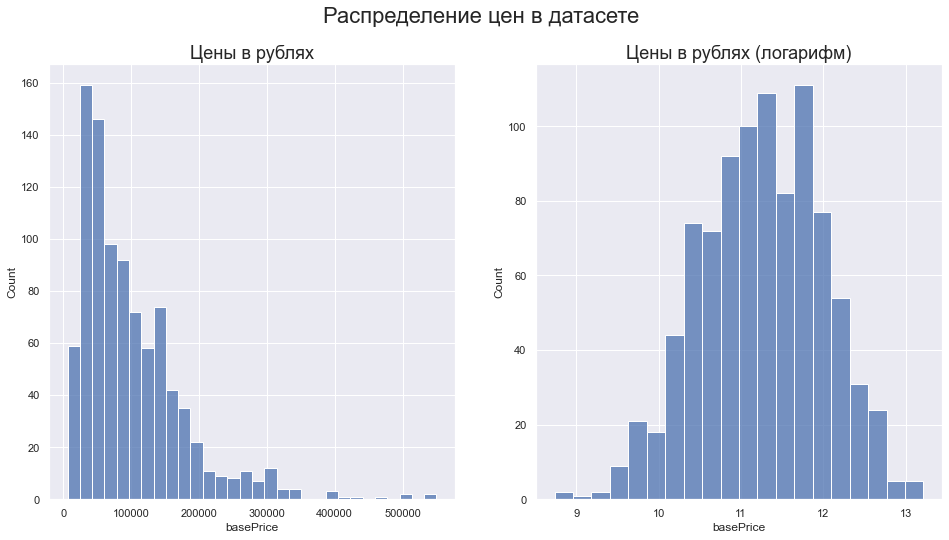

In [9]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Распределение цен в датасете', size=22)
axes[0].set_title("Цены в рублях", size=18)
sns.histplot(df.basePrice, ax=axes[0]);
axes[1].set_title("Цены в рублях (логарифм)", size=18)
sns.histplot(np.log1p(df.basePrice), ax=axes[1])
plt.show()

> Распределение логарифмическое, с тяжелоым правым хвостом.  
> Будем предсказывать логарифм цены, а потом его преобразовывать, возможно это поможет.

# Бренд

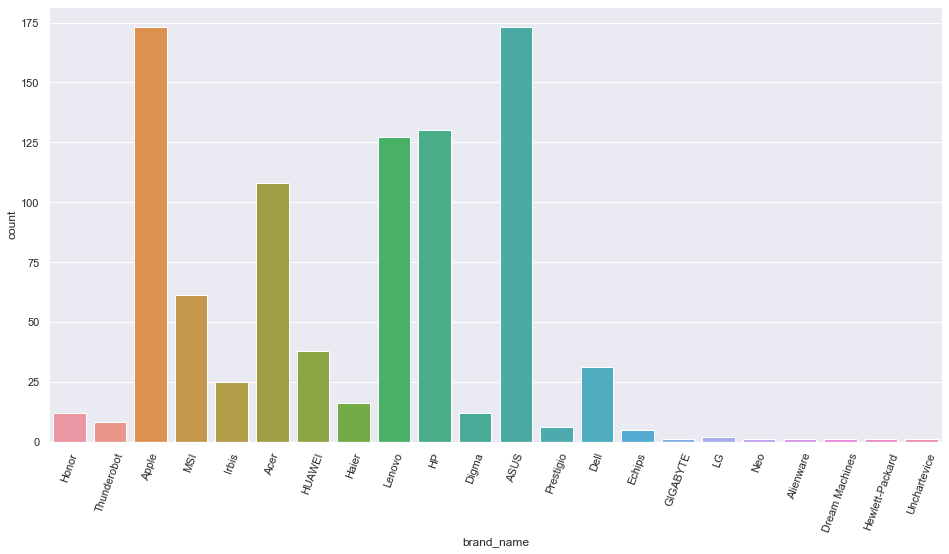

In [10]:
sns.countplot(x=df.brand_name)
plt.xticks(rotation = 70)
plt.show()

> Оставим только самые топовые бренды, остальные схлопнем в категорию "другие"

# Процессор

In [11]:
df["Процессор_Процессор"].sample(5)

30051363    Intel Core i3 1005G1 1.2 ГГц
30061050    Intel Core i5 1135G7 2.4 ГГц
30057477     Intel Celeron N4020 1.1 ГГц
30039126             AMD A4 9125 2.3 ГГц
30042211         AMD Ryzen 5 2500U 2 ГГц
Name: Процессор_Процессор, dtype: object

> В процессора у нас зашита частота, ее нужно вытащить   
> Также нужно выделить название процессора "Inter Core i3", "AMD Ryzen 5", "Apple M2"

In [12]:
df.loc[df.brand_name == "Apple", "Процессор_Процессор"]

30064594                         Apple M2
30064275                         Apple M1
30065173                     Apple M1 Pro
30065174                     Apple M1 Pro
30064278                         Apple M1
                         ...             
400029647            Apple M2 M2 3.49 ГГц
400027899    Apple M1 Pro M1 Pro 3.22 ГГц
400027919            Apple M2 M2 3.49 ГГц
400027896    Apple M1 Pro M1 Pro 3.22 ГГц
400029644    Apple M1 Pro M1 Pro 3.22 ГГц
Name: Процессор_Процессор, Length: 173, dtype: object

> Есть зависимость, для Apple могут быть только Apple процессоры

In [13]:
proc = df["Процессор_Процессор"]

In [14]:
def get_frequency(column):
    values = column.split()
    if (values and values[-1] == "ГГц"):
        return float(values[-2])
    else:
        return np.NAN

In [15]:
proc.apply(get_frequency)

30062056     1.60
30065211     2.00
30056687     1.60
30064594      NaN
30061606     2.70
             ... 
400027919    3.49
4183550      2.30
400027896    3.22
400029644    3.22
4129209      2.40
Name: Процессор_Процессор, Length: 933, dtype: float64

In [16]:
proc.apply(lambda x: x.split()[0]).head()
    

30062056    Intel
30065211    Intel
30056687    Intel
30064594    Apple
30061606    Intel
Name: Процессор_Процессор, dtype: object

In [17]:
def get_proc_name(column):
    values = column.split()
    if not values:
        return np.NAN
    if (values[0] == "Intel" and values[1] == "Core"):
        return " ".join(values[0:3])
    else:
        return " ".join(values[0:2])

In [18]:
proc.apply(get_proc_name).value_counts(normalize=True)

Intel Core i5          0.206860
AMD Ryzen              0.188639
Intel Core i7          0.127546
Apple M1               0.100750
Intel Core i3          0.097535
Intel Celeron          0.092176
Apple M2               0.056806
Intel Pentium          0.056806
AMD Athlon             0.022508
Intel Core i9          0.016077
Intel Atom             0.006431
AMD 3000               0.005359
AMD A4                 0.005359
AMD A6                 0.004287
AMD E2                 0.003215
Intel Intel            0.002144
AMD A10                0.002144
Core i5                0.001072
Qualcomm Snapdragon    0.001072
Qualcomm Kryo          0.001072
AMD A12                0.001072
Zhaoxin KX-6640MA      0.001072
Name: Процессор_Процессор, dtype: float64

> Если не проходит 5% барьер то оставим только название бренда

In [19]:
count = proc.apply(get_proc_name).value_counts(normalize=True)
popular_names = count[count > 0.05].index

In [20]:
"Intel Core i5" in popular_names

True

In [21]:
None is None

True

In [22]:
def get_proc_name(column, popular_names=None):
    values = column.split()
    if not values:
        return np.NAN
    if (values[0] == "Intel" and values[1] == "Core"):
        result = " ".join(values[0:3])
    else:
        result = " ".join(values[0:2])
    
    if not popular_names is None:
        if result not in popular_names:
            result = values[0]
    return result

In [23]:
proc.apply(get_proc_name, popular_names=popular_names).value_counts()

Intel Core i5    193
AMD Ryzen        176
Intel Core i7    119
Apple M1          94
Intel Core i3     91
Intel Celeron     86
Apple M2          53
Intel Pentium     53
AMD               41
Intel             23
Qualcomm           2
Core               1
Zhaoxin            1
Name: Процессор_Процессор, dtype: int64

> Нужно заполнить не указанную частоту процессора  
> Будем смотреть по модели 

In [24]:
proc_brand = proc.apply(get_proc_name, popular_names=popular_names)
proc_freq = proc.apply(get_frequency)

In [25]:
df_brand_freq = pd.DataFrame.from_dict({
    "brand" : proc_brand,
    "freq" : proc_freq
})

In [26]:
df_brand_freq.groupby("brand").freq.transform(lambda x: x.fillna(x.mean()))


30062056     1.60
30065211     2.00
30056687     1.60
30064594     3.49
30061606     2.70
             ... 
400027919    3.49
4183550      2.30
400027896    3.22
400029644    3.22
4129209      2.40
Name: freq, Length: 933, dtype: float64

In [27]:
df_brand_freq["freq_fill"] = df_brand_freq.groupby("brand").freq.transform(lambda x: x.fillna(x.mean()))

In [28]:
df_brand_freq

,brand,freq,freq_fill
30062056,Intel Core i5,1.60,1.60
30065211,Intel Core i5,2.00,2.00
30056687,Intel Core i5,1.60,1.60
30064594,Apple M2,NaN,3.49
30061606,Intel Core i5,2.70,2.70
...,...,...,...
400027919,Apple M2,3.49,3.49
4183550,Intel Celeron,2.30,2.30
400027896,Apple M1,3.22,3.22
400029644,Apple M1,3.22,3.22


# Количество ядер

In [29]:
df["Процессор_Количество ядер"].sample(5)

30062352    2.0
30060175    4.0
30058342    8.0
30050010    4.0
30059486    4.0
Name: Процессор_Количество ядер, dtype: float64

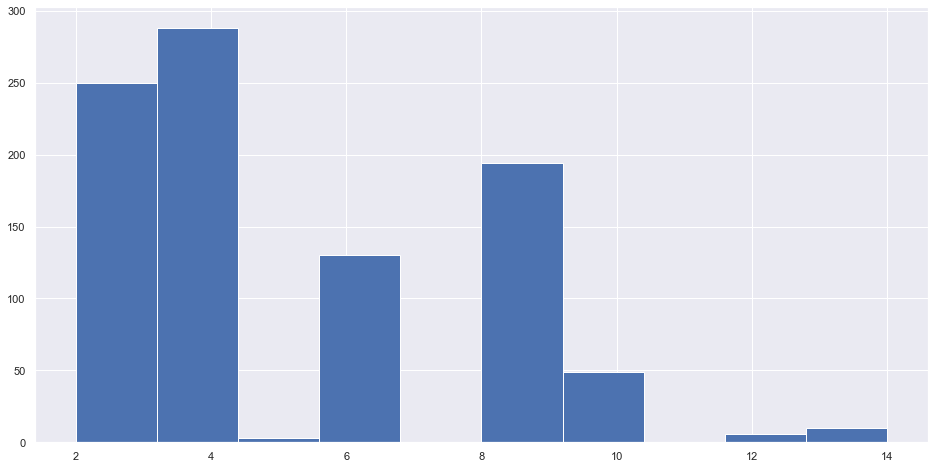

In [30]:
df["Процессор_Количество ядер"].hist();

In [31]:
df["Процессор_Количество ядер"].info()

<class 'pandas.core.series.Series'>
Int64Index: 933 entries, 30062056 to 4129209
Series name: Процессор_Количество ядер
Non-Null Count  Dtype  
--------------  -----  
930 non-null    float64
dtypes: float64(1)
memory usage: 14.6 KB


> Заполним пропуски также, по модели процессора

# Видеокарта_Производитель видеопроцессора

In [32]:
df[["Видеокарта_Производитель видеопроцессора", "Видеокарта_Графический контроллер"]].sample(10)

,Видеокарта_Производитель видеопроцессора,Видеокарта_Графический контроллер
30065633,Intel,Intel UHD Graphics
30063861,Intel,Intel Iris Graphics
30062490,NVIDIA,GeForce MX450 2ГБ
30062301,AMD,Radeon Graphics
30047479,AMD,Radeon Pro 5500M 4ГБ
30062364,NVIDIA,GeForce MX350 2ГБ
30054301,None,None
30056456,Qualcomm,Adreno 685
30061286,AMD,Radeon Vega
400005050,NVIDIA,GeForce RTX 3050 Ti для ноутбуков 4GB


In [33]:
df["Видеокарта_Производитель видеопроцессора"].value_counts()

Intel       383
NVIDIA      218
AMD         181
Apple        37
Qualcomm      2
UMA           1
Zhaoxin       1
Name: Видеокарта_Производитель видеопроцессора, dtype: int64

In [34]:
df[["Видеокарта_Производитель видеопроцессора", "Видеокарта_Графический контроллер"]].isna().sum()

Видеокарта_Производитель видеопроцессора    110
Видеокарта_Графический контроллер            87
dtype: int64

In [35]:
df["Видеокарта_Графический контроллер"].value_counts()

Intel UHD Graphics                    101
Intel Iris Xe Graphics                101
Radeon Graphics                        82
интегрированная                        62
GeForce RTX 3050 для ноутбуков 4GB     34
                                     ... 
GeForce RTX 2070 8GB Max-Q Design       1
Radeon R8 M445DX 2ГБ                    1
Radeon R8 M435DX                        1
GeForce MX350                           1
C-960 Graphics                          1
Name: Видеокарта_Графический контроллер, Length: 97, dtype: int64

In [36]:
df.loc[df["Видеокарта_Графический контроллер"].isna(), "Видеокарта_Графический контроллер"] = "интегрированная"
df.loc[df["Видеокарта_Графический контроллер"].str.contains("Intel"), "Видеокарта_Графический контроллер"] = "интегрированная"

In [37]:
df["Видеокарта_Графический контроллер"].value_counts()

интегрированная                          502
Radeon Graphics                           82
GeForce RTX 3050 для ноутбуков 4GB        34
GeForce RTX 3050 Ti для ноутбуков 4GB     29
GeForce RTX 3060 для ноутбуков 6GB        23
                                        ... 
Radeon 535 2ГБ                             1
Radeon RX 560X 2ГБ                         1
GeForce RTX 3050 4GB + RTX 3080 16GB       1
Adreno 618                                 1
C-960 Graphics                             1
Name: Видеокарта_Графический контроллер, Length: 76, dtype: int64

In [38]:
def get_video_memory(column):
    if not column or column == "интегрированная":
        return 0
    values = column.split()
    if (values and values[-1].endswith("GB")):
        return int(values[-1].replace("GB", ""))
    else:
        return np.NAN

In [39]:
df["Видеокарта_Графический контроллер"].apply(get_video_memory).value_counts()

0.0     502
4.0      87
8.0      28
6.0      27
16.0      5
2.0       5
3.0       4
10.0      2
12.0      1
Name: Видеокарта_Графический контроллер, dtype: int64

In [40]:
df.loc[df["Видеокарта_Графический контроллер"].str.contains("GeForce RTX"), "Видеокарта_Графический контроллер"] = "GeForce RTX"
df.loc[df["Видеокарта_Графический контроллер"].str.contains("GeForce GTX"), "Видеокарта_Графический контроллер"] = "GeForce GTX"
df.loc[df["Видеокарта_Графический контроллер"].str.contains("Radeon"), "Видеокарта_Графический контроллер"] = "Radeon"

df.loc[df["Видеокарта_Графический контроллер"].str.contains("UHD Graphics"), "Видеокарта_Графический контроллер"] = "интегрированная"

df.loc[df["Видеокарта_Графический контроллер"].str.contains("GeForce MX"), "Видеокарта_Графический контроллер"] = "GeForce MX"


In [41]:
df["Видеокарта_Графический контроллер"].value_counts()[:20]

интегрированная         532
Radeon                  182
GeForce RTX             121
GeForce GTX              51
GeForce MX               42
NVIDIA RTX A3000 6GB      1
Adreno 685                1
Adreno 618                1
Quadro T1000 4ГБ          1
C-960 Graphics            1
Name: Видеокарта_Графический контроллер, dtype: int64

> Оставим эти категории, редкие объединим в другое  
> Определим объем памяти по средней в группе по видеокарте

# Диагональ экрана

In [42]:
df["Экран_Диагональ экрана"]

30062056     15.6"(39.6 см)
30065211     17.3"(43.9 см)
30056687     15.6"(39.6 см)
30064594               None
30061606     17.3"(43.9 см)
                  ...      
400027919              None
4183550      15.6"(39.6 см)
400027896              None
400029644              None
4129209        14"(35.5 см)
Name: Экран_Диагональ экрана, Length: 933, dtype: object

In [43]:
a = df["Экран_Диагональ экрана"].apply(lambda x: np.NAN if not x else int(float(x.split('"')[0])))

In [44]:
a.fillna(a.mode()[0])

30062056     15.0
30065211     17.0
30056687     15.0
30064594     15.0
30061606     17.0
             ... 
400027919    15.0
4183550      15.0
400027896    15.0
400029644    15.0
4129209      14.0
Name: Экран_Диагональ экрана, Length: 933, dtype: float64

# Объем SSD

In [45]:
df["Жесткий диск_Объем SSD"]

30062056     512 ГБ
30065211     512 ГБ
30056687     512 ГБ
30064594     256 ГБ
30061606     512 ГБ
              ...  
400027919    256 ГБ
4183550      240 ГБ
400027896    512 ГБ
400029644    512 ГБ
4129209      120 ГБ
Name: Жесткий диск_Объем SSD, Length: 933, dtype: object

In [46]:
def convert_volume_to_number(val):
    if not val:
        return 0
    num, item = val.split()
    num = int(num)
    if item.lower() == "тб":
        return 1024 * num
    else:
        return num

In [47]:
df["Жесткий диск_Объем SSD"].apply(convert_volume_to_number).value_counts()

512     391
256     245
0       101
1024     92
128      67
2048     15
8192      9
4096      5
64        2
240       2
32        2
500       1
120       1
Name: Жесткий диск_Объем SSD, dtype: int64

# Оперативная память

In [48]:
df["Оперативная память_Оперативная память (RAM)"]

30062056     16
30065211     16
30056687      8
30064594      8
30061606     16
             ..
400027919     8
4183550       8
400027896    16
400029644    16
4129209       6
Name: Оперативная память_Оперативная память (RAM), Length: 933, dtype: int64

# Интерфейсы_Выход HDMI

In [49]:
df["Интерфейсы_Выход HDMI"]

30062056     1.0
30065211     1.0
30056687     1.0
30064594     NaN
30061606     1.0
            ... 
400027919    NaN
4183550      1.0
400027896    NaN
400029644    NaN
4129209      1.0
Name: Интерфейсы_Выход HDMI, Length: 933, dtype: float64

In [50]:
df[df["Интерфейсы_Выход HDMI"].isna()].head()

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память,...,Жесткий диск_Объем гибридного SSHD,Передача данных_Модуль 3G,Передача данных_Поддержка 4G LTE,Передача данных_Поддержка 5G,Интерфейсы_Разъем для микрофона 3.5 мм,Интерфейсы_Выход D-Sub видео,Процессор_Платформа Intel Evo,basePrice,basePromoPrice,salePrice
30064594,Apple,https://www.mvideo.ru/products/noutbuk-apple-m...,1 год,Китай,MacBook Pro,macOS,None,Apple M2,8.0,NaN,...,NaN,None,None,None,NaN,NaN,None,139999,NaN,139999
30057684,Irbis,https://www.mvideo.ru/products/noutbuk-irbis-n...,1 год,Китай,None,Windows 10,установлена,Intel Pentium Intel Pentium J3710 1.6 ГГц,4.0,2.0,...,NaN,None,None,None,NaN,NaN,None,25999,19999.0,19999
30062364,Acer,https://www.mvideo.ru/products/noutbuk-acer-as...,1 год,Китай,None,Windows 11 Домашняя,установлена,Intel Core i5 1135G7 2.4 ГГц,2.0,6.0,...,NaN,None,None,None,NaN,NaN,None,69999,NaN,69999
30063454,Haier,https://www.mvideo.ru/products/noutbuk-haier-p...,1 год,Китай,None,DOS,не установлена,Intel Pentium N5030 1.1 ГГц,4.0,4.0,...,NaN,None,None,None,NaN,NaN,None,32999,29999.0,29999
30063451,Haier,https://www.mvideo.ru/products/noutbuk-haier-u...,1 год,Китай,URBAN,Windows 11 Домашняя,установлена,Intel Celeron N4020 1.1 ГГц,2.0,4.0,...,NaN,None,None,None,NaN,NaN,None,24999,21999.0,21999


> Добавим фичу есть ли выход hdmi

# Материал корпуса

In [51]:
df["Корпус_Материал корпуса"].value_counts()

пластик                       411
алюминий                      202
алюминиевый сплав              86
металл                         66
алюминий/ пластик              53
пластик/ металл                47
металл/ пластик                16
пластик/ алюминий              15
ABS-пластик                    10
магниевый сплав                 8
алюминиевый сплав/ пластик      7
углеродное волокно              3
магний/ алюминий                2
магний                          1
металл/ кожа                    1
алюминий/ поликарбонат          1
анодированный алюминий          1
Name: Корпус_Материал корпуса, dtype: int64

In [52]:
df.loc[~df["Корпус_Материал корпуса"].isna() & df["Корпус_Материал корпуса"].str.contains("алюмин|металл|сплав|магний"), "Корпус_Материал корпуса"] = "металл"
df.loc[~df["Корпус_Материал корпуса"].isna() & df["Корпус_Материал корпуса"].str.contains("пластик|углерод|поликарб"), "Корпус_Материал корпуса"] = "пластик"

In [53]:
df["Корпус_Материал корпуса"].value_counts()

металл     506
пластик    424
Name: Корпус_Материал корпуса, dtype: int64

In [54]:
df["Корпус_Материал корпуса"].info()

<class 'pandas.core.series.Series'>
Int64Index: 933 entries, 30062056 to 4129209
Series name: Корпус_Материал корпуса
Non-Null Count  Dtype 
--------------  ----- 
930 non-null    object
dtypes: object(1)
memory usage: 14.6+ KB


In [55]:
df[df["Корпус_Материал корпуса"].isna()]

,brand_name,url,Заводские данные_Гарантия,Заводские данные_Страна,Серия модели_Серия,Операционная система_Операционная система,Операционная система_ОС Windows,Процессор_Процессор,Процессор_Количество ядер,Процессор_Кэш-память,...,Жесткий диск_Объем гибридного SSHD,Передача данных_Модуль 3G,Передача данных_Поддержка 4G LTE,Передача данных_Поддержка 5G,Интерфейсы_Разъем для микрофона 3.5 мм,Интерфейсы_Выход D-Sub видео,Процессор_Платформа Intel Evo,basePrice,basePromoPrice,salePrice
30058178,HP,https://www.mvideo.ru/products/noutbuk-dlya-bi...,1 год,Китай,250 G7,Windows 10 Домашняя,установлена,Intel Celeron N4020 1.1 ГГц,2.0,NaN,...,NaN,None,None,None,NaN,NaN,None,24999,NaN,24999
30058177,HP,https://www.mvideo.ru/products/noutbuk-dlya-bi...,1 год,Китай,250 G7,None,не установлена,Intel Celeron N4020 1.1 ГГц,2.0,NaN,...,NaN,None,None,None,NaN,NaN,None,25999,NaN,25999
30051446,MSI,https://www.mvideo.ru/products/noutbuk-igrovoi...,2 года,Китай,CREATOR 15,Windows 10,установлена,Intel Core i7 10875H 2.3 ГГц,8.0,16.0,...,NaN,None,None,None,NaN,NaN,None,214999,NaN,214999


# Электропитание_Работа от аккумулятора

In [56]:
df["Электропитание_Работа от аккумулятора"].value_counts()

до 5 часов         146
до 7 часов         126
до 6 часов         100
до 8 часов          74
до 10 часов         49
до 9 часов          47
до 11 часов         39
до 17 часов         30
до 12 часов         28
до 18 часов         26
до 20 часов         21
до 15 часов         17
до 14 часов         12
до 21 часа          12
до 4 часов          10
до 13 часов         10
до 6 ч 30 мин       10
до 5 ч 30 мин        8
до 8 ч 45 мин        6
до 16 часов          6
до 5 ч 10 мин        6
до 4 ч 50 мин        5
до 7 ч 45 мин        4
до 12 ч 30 мин       4
до 9 ч 30 мин        4
до 4 ч 30 мин        4
до 10 ч 30 мин       4
до 7 ч 30 мин        4
до 5 ч 50 мин        3
до 15 ч 30 мин       3
до 8 ч 30 мин        3
до 11 ч 30 мин       2
до 9 ч 30 минут      2
до 3 часов           2
до 29 часов          1
до 13 ч 30 мин       1
до 25 часов          1
до 3 ч 30 мин        1
до 5 ч 45 мин        1
до 3 ч 55 мин        1
до 4 ч 10 мин        1
Name: Электропитание_Работа от аккумулятора, dtype: int64

In [57]:
df["Электропитание_Работа от аккумулятора"].apply(lambda x: np.NaN if not x else x.split()[1])

30062056       7
30065211       5
30056687       7
30064594      20
30061606       5
            ... 
400027919    NaN
4183550        5
400027896    NaN
400029644    NaN
4129209        5
Name: Электропитание_Работа от аккумулятора, Length: 933, dtype: object

# Функция для подготовки данных

In [6]:
def replace_rare_category(column: pd.Series, percent: float = 0.05, replace_with: str = "other") -> pd.Series:
    counts = column.value_counts(normalize=True)
    rare_categories = counts[counts < percent].index
    return column.replace(dict.fromkeys(rare_categories, replace_with))


def proc_frequency(proc: str) -> float:
    values = proc.split()
    if values and values[-1] == "ГГц":
        return float(values[-2])
    else:
        return np.NAN


def get_video_memory(column):
    if not column or column == "интегрированная":
        return 0
    values = column.split()
    if values and values[-1].endswith("GB"):
        return int(values[-1].replace("GB", ""))
    else:
        return np.NAN


def get_proc_name(proc: str, popular_names: list = None):
    values = proc.split()
    if not values:
        return np.NAN
    if values[0] == "Intel" and values[1] == "Core":
        result = " ".join(values[0:3])
    else:
        result = " ".join(values[0:2])

    if not popular_names is None:
        if result not in popular_names:
            result = values[0]
    return result


def convert_volume_to_number(val):
    if not val:
        return 0
    num, item = val.split()
    num = int(num)
    if item.lower() == "тб":
        return 1024 * num
    else:
        return num


def fill_na(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()
    df_new["proc_freq"] = df_new.groupby("proc_brand").proc_freq.transform(lambda x: x.fillna(x.mean()))
    df_new["proc_count"] = df_new.groupby("proc_brand").proc_count.transform(lambda x: x.fillna(x.mean()))
    df_new["videocard_memory"] = df_new.groupby("videocard").videocard_memory.transform(
        lambda x: x.fillna(np.NaN if not x.count() else x.mode()[0]))
    df_new["videocard_memory"] = df_new["videocard_memory"].fillna(0)
    df_new["screen"] = df_new["screen"].fillna(df_new["screen"].mode()[0])
    df_new["material"] = df_new["material"].fillna(df_new["material"].mode()[0])
    df_new["battery_life"] = df_new.groupby("brand_name").battery_life.transform(lambda x: x.fillna(x.mean()))
    return df_new


def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    selected_features = [
        "brand_name"
    ]

    df_new = df[selected_features].copy()
    df_new["priceLog"] = np.log1p(df.basePrice)

    df_new["brand_name"] = replace_rare_category(df_new["brand_name"])
    df_new["brand_name"] = df_new["brand_name"].str.lower()

    df_new["proc_freq"] = df["Процессор_Процессор"].apply(proc_frequency)
    df_new["proc_brand"] = df["Процессор_Процессор"].apply(lambda x: x.split()[0])
    df_new["proc_brand"] = df_new["proc_brand"].str.lower()

    proc_names_counts = df["Процессор_Процессор"].apply(get_proc_name).value_counts(normalize=True)
    popular_proc_names = proc_names_counts[proc_names_counts > 0.05].index
    df_new["proc_name"] = df["Процессор_Процессор"].apply(get_proc_name, args=(popular_proc_names,))
    df_new["proc_name"] = df_new["proc_name"].str.lower()

    df_new["proc_count"] = df["Процессор_Количество ядер"]

    df_new["videocard"] = df["Видеокарта_Графический контроллер"]
    df_new.loc[df_new["videocard"].isna(), "videocard"] = "интегрированная"
    df_new.loc[df_new["videocard"].str.contains("Intel"), "videocard"] = "интегрированная"
    df_new.loc[df_new["videocard"].str.contains("UHD Graphics"), "videocard"] = "интегрированная"

    df_new["videocard_memory"] = df_new["videocard"].apply(get_video_memory)

    df_new.loc[df_new["videocard"].str.contains("GeForce RTX"), "videocard"] = "GeForce RTX"
    df_new.loc[df_new["videocard"].str.contains("GeForce GTX"), "videocard"] = "GeForce GTX"
    df_new.loc[df_new["videocard"].str.contains("GeForce MX"), "videocard"] = "GeForce MX"
    df_new.loc[df_new["videocard"].str.contains("Radeon"), "videocard"] = "Radeon"
    df_new["videocard"] = replace_rare_category(df_new["videocard"], percent=0.03)
    df_new["videocard"] = df_new["videocard"].str.lower()

    df_new["screen"] = df["Экран_Диагональ экрана"].apply(lambda x: np.NAN if not x else int(float(x.split('"')[0])))

    df_new["ssd_volume"] = df["Жесткий диск_Объем SSD"].apply(convert_volume_to_number)
    df_new["ram"] = df["Оперативная память_Оперативная память (RAM)"]
    df_new["hdmi"] = ~df["Интерфейсы_Выход HDMI"].isna()

    df_new["material"] = df["Корпус_Материал корпуса"]
    df_new.loc[~df_new["material"].isna() & df_new["material"].str.contains("алюмин|металл|сплав|магний"), "material"] = "металл"
    df_new.loc[~df_new["material"].isna() & df_new["material"].str.contains("пластик|углерод|поликарб"), "material"] = "пластик"

    df_new["battery_life"] = df["Электропитание_Работа от аккумулятора"].apply(lambda x: np.NaN if not x else float(x.split()[1]))

    return df_new



In [7]:
df_clean = pd.read_parquet(PATH, engine="pyarrow")
df_prepared = prepare_data(df_clean)
df_prepared = fill_na(df_prepared)
display(df_prepared.head())
display(df_prepared.info())

,brand_name,priceLog,proc_freq,proc_brand,proc_name,proc_count,videocard,videocard_memory,screen,ssd_volume,ram,hdmi,material,battery_life
30062056,other,11.156251,1.600000,intel,intel core i5,4.0,интегрированная,0.0,15.0,512,16,True,металл,7.0
30065211,other,11.561716,2.000000,intel,intel core i5,8.0,geforce rtx,4.0,17.0,512,16,True,пластик,5.0
30056687,other,11.002100,1.600000,intel,intel core i5,4.0,интегрированная,0.0,15.0,512,8,True,металл,7.0
30064594,apple,11.849398,3.406613,apple,apple m2,8.0,интегрированная,0.0,15.0,256,8,False,металл,20.0
30061606,msi,11.775290,2.700000,intel,intel core i5,6.0,geforce rtx,6.0,17.0,512,16,True,металл,5.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 30062056 to 4129209
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand_name        933 non-null    object 
 1   priceLog          933 non-null    float64
 2   proc_freq         933 non-null    float64
 3   proc_brand        933 non-null    object 
 4   proc_name         933 non-null    object 
 5   proc_count        933 non-null    float64
 6   videocard         933 non-null    object 
 7   videocard_memory  933 non-null    float64
 8   screen            933 non-null    float64
 9   ssd_volume        933 non-null    int64  
 10  ram               933 non-null    int64  
 11  hdmi              933 non-null    bool   
 12  material          933 non-null    object 
 13  battery_life      933 non-null    float64
dtypes: bool(1), float64(6), int64(2), object(5)
memory usage: 103.0+ KB


None

In [14]:
from IPython.core.display import HTML

In [17]:
for x in df_prepared.columns:
    display(HTML(f'<h3>{x}</h3>'))
    if df_prepared[x].dtype == "object":
        print(df_prepared[x].unique())
    else:
        print(df_prepared[x].describe())

['other' 'apple' 'msi' 'acer' 'lenovo' 'hp' 'asus']


count    933.000000
mean      11.245048
std        0.751277
min        8.736489
25%       10.714418
50%       11.289669
75%       11.820344
max       13.217674
Name: priceLog, dtype: float64


count    933.000000
mean       2.359155
std        0.786189
min        0.000000
25%        1.800000
50%        2.400000
75%        3.100000
max        3.700000
Name: proc_freq, dtype: float64


['intel' 'apple' 'amd' 'core' 'qualcomm' 'zhaoxin']


['intel core i5' 'apple m2' 'intel pentium' 'intel core i3'
 'intel core i7' 'amd ryzen' 'intel celeron' 'amd' 'apple m1' 'intel'
 'core' 'qualcomm' 'zhaoxin']


count    933.000000
mean       5.051682
std        2.689809
min        2.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       14.000000
Name: proc_count, dtype: float64


['интегрированная' 'geforce rtx' 'geforce mx' 'radeon' 'geforce gtx'
 'other']


count    933.000000
mean       2.533762
std        3.494660
min        0.000000
25%        0.000000
50%        0.000000
75%        6.000000
max       16.000000
Name: videocard_memory, dtype: float64


count    933.000000
mean      14.741693
std        1.066837
min       10.000000
25%       14.000000
50%       15.000000
75%       15.000000
max       17.000000
Name: screen, dtype: float64


count     933.000000
mean      527.241158
std       871.541749
min         0.000000
25%       256.000000
50%       512.000000
75%       512.000000
max      8192.000000
Name: ssd_volume, dtype: float64


count    933.000000
mean      10.853162
std        7.434758
min        2.000000
25%        8.000000
50%        8.000000
75%       16.000000
max       64.000000
Name: ram, dtype: float64


count      933
unique       2
top       True
freq       581
Name: hdmi, dtype: object


['металл' 'пластик']


count    933.000000
mean       9.397420
std        4.588532
min        3.000000
25%        6.000000
50%        8.000000
75%       12.000000
max       29.000000
Name: battery_life, dtype: float64
